In [155]:
import warnings; warnings.simplefilter('ignore')
import os, codecs, string, random
import pandas as pd
import numpy as np
from numpy.random import seed as random_seed
from numpy.random import shuffle as random_shuffle
import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns
sns.set()
#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
import math
from statsmodels.stats import diagnostic
from scipy import stats
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [156]:
DATA_FOLDER = ''

MASS_SHOOTINGS_15 = DATA_FOLDER+"massshootings15.csv"
MASS_SHOOTINGS_16 = DATA_FOLDER+"massshootings16.csv"
MASS_SHOOTINGS_17 = DATA_FOLDER+"massshootings17.csv"
MASS_SHOOTINGS_18 = DATA_FOLDER+"massshootings18.csv"
MASS_SHOOTINGS_19 = DATA_FOLDER+"massshootings19.csv"

QUOTEBANK = DATA_FOLDER+"quotes_bert_tok.pkl"

In [157]:
mass_shootings_15 = pd.read_csv(MASS_SHOOTINGS_15)
mass_shootings_16 = pd.read_csv(MASS_SHOOTINGS_16)
mass_shootings_17 = pd.read_csv(MASS_SHOOTINGS_17)
mass_shootings_18 = pd.read_csv(MASS_SHOOTINGS_18)
mass_shootings_19 = pd.read_csv(MASS_SHOOTINGS_19)
quotes = pd.read_pickle(QUOTEBANK)

In [158]:
mass_shootings=pd.concat([mass_shootings_15, mass_shootings_16, mass_shootings_17, mass_shootings_18,
                          mass_shootings_19], ignore_index=True)



In [159]:
mass_shootings = mass_shootings.drop(columns=['State', 'City Or County', 'Address', 'Operations', '# Injured'])
mass_shootings['date'] = pd.to_datetime(mass_shootings['Incident Date'], infer_datetime_format=True)

mass_shootings = mass_shootings.drop(columns=['Incident Date'])
mass_shootings['date'] = mass_shootings['date']

quotes['date'] = pd.to_datetime(quotes['date']).astype('datetime64')

In [160]:
quotes.head()

,speaker,qids,date,quotation,keyword,scores,compound,sent_type,tokens,N_of_tokens,Bert_sentiment_type,Tok_Bert
0,President Obama,[Q76],2015-07-23,If you look at the number killed by gun violen...,gun violence,"{'neg': 0.213, 'neu': 0.733, 'pos': 0.054, 'co...",-0.8271,NEG,"[If, you, look, at, the, number, killed, by, g...",53,neutral,59
1,Ted Cruz,[Q2036942],2015-04-21,"So far, Ted Cruz, in my opinion would be best ...",gun owner,"{'neg': 0.114, 'neu': 0.714, 'pos': 0.171, 'co...",0.5256,POS,"[So, far, ,, Ted, Cruz, ,, in, my, opinion, wo...",40,neutral,42
2,Hillary Rodham Clinton,[Q6294],2015-10-25,"Stopping gun violence is worth fighting for, a...",gun violence,"{'neg': 0.505, 'neu': 0.286, 'pos': 0.21, 'com...",-0.7351,NEG,"[Stopping, gun, violence, is, worth, fighting,...",15,positive,19
3,Fareed Zakaria,[Q333425],2015-12-07,The rest of the world looks at this as the one...,gun violence,"{'neg': 0.189, 'neu': 0.755, 'pos': 0.057, 'co...",-0.9230,NEG,"[The, rest, of, the, world, looks, at, this, a...",97,negative,107
4,Andy Yen,[Q23759707],2015-11-25,"With or without ProtonMail, ISIS will continue...",gun law,"{'neg': 0.166, 'neu': 0.834, 'pos': 0.0, 'comp...",-0.6569,NEG,"[With, or, without, ProtonMail, ,, ISIS, will,...",38,negative,47


In [161]:
mass_shootings.sort_values(by='# Killed', ascending=False).head()

,Incident ID,# Killed,date
788,946496,59,2017-10-01
581,577157,50,2016-06-12
754,980577,27,2017-11-05
1574,1466705,23,2019-08-03
1372,1049217,17,2018-02-14


In [162]:
quotes_by_day = quotes.groupby('date').count()['quotation'].to_frame(name = 'num_quotes').reset_index()
quotes_by_day.sort_values(by='num_quotes', ascending=False)

,date,num_quotes
859,2017-10-03,590
1001,2018-02-22,490
994,2018-02-15,487
858,2017-10-02,410
1000,2018-02-21,379
...,...,...
609,2017-01-12,1
608,2017-01-11,1
607,2017-01-09,1
606,2017-01-03,1


In [163]:
deathsbyday = mass_shootings.groupby('date').sum()['# Killed'].to_frame(name = 'killed').reset_index()
deathsbyday = deathsbyday[deathsbyday['killed']>0]
deathsbyday.sort_values(by='killed', ascending=False)

,date,killed
556,2017-10-01,62
275,2016-06-12,50
577,2017-11-05,27
936,2019-08-03,23
624,2018-02-14,17
...,...,...
457,2017-04-13,1
454,2017-04-06,1
444,2017-03-19,1
438,2017-03-04,1


In [164]:
death_and_quotes = deathsbyday.merge(quotes_by_day, on='date', how='outer').fillna(0)
death_and_quotes.sort_values(by='num_quotes', ascending=False).head()

,date,killed,num_quotes
1232,2017-10-03,0.0,590.0
1330,2018-02-22,0.0,490.0
1325,2018-02-15,0.0,487.0
1231,2017-10-02,0.0,410.0
1329,2018-02-21,0.0,379.0


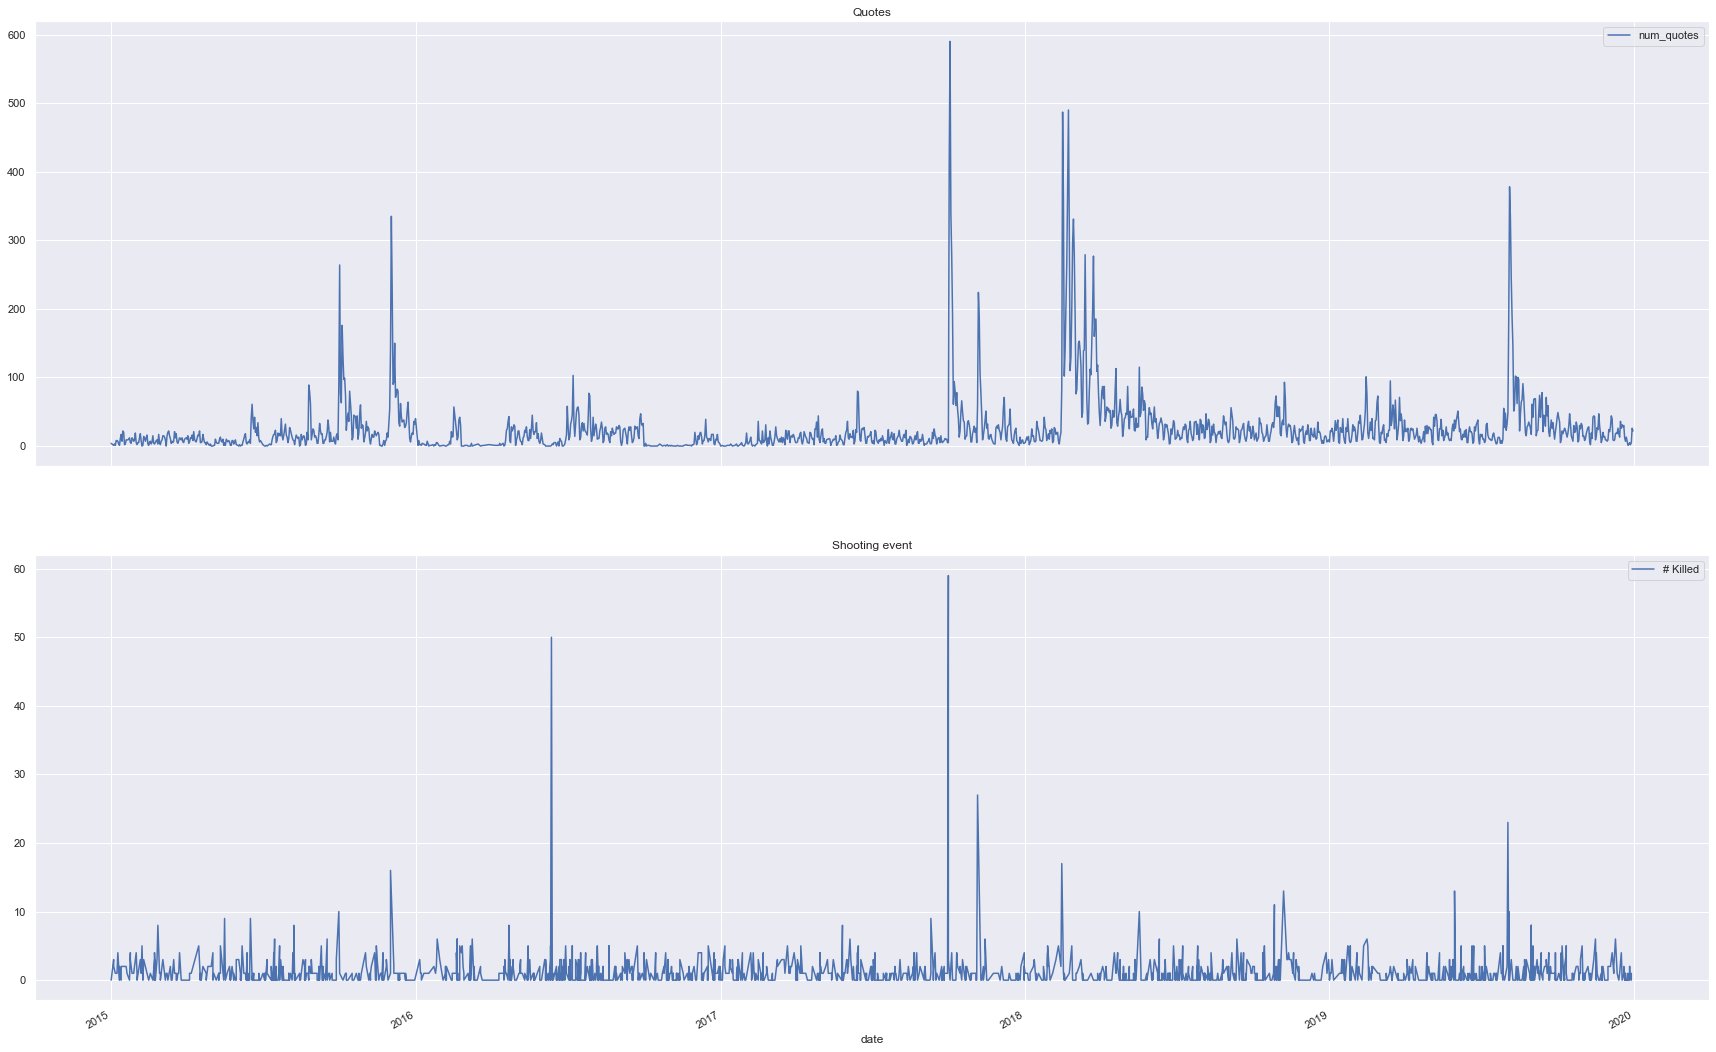

In [165]:
fig, axs = plt.subplots(2, 1, sharex=True)
mass_shootings.plot(x='date', y='# Killed', figsize=(30,20), ax=axs[1], grid='True');
death_and_quotes.plot(x='date', y='num_quotes', figsize=(30,20), ax=axs[0], grid='True');
axs[0].set_title('Quotes');
axs[1].set_title('Shooting event');

In [212]:
selected_shooting = mass_shootings[mass_shootings['# Killed']>=7].sort_values(by='date').drop([237, 297, 811, 1671, 1538])
selected_shooting.to_csv('selected_shooting.csv')
selected_shooting

,Incident ID,# Killed,date
197,359830,9,2015-06-17
128,390526,8,2015-08-08
66,423223,10,2015-10-01
18,456893,16,2015-12-02
639,545525,8,2016-04-22
581,577157,50,2016-06-12
931,853756,8,2017-05-27
788,946496,59,2017-10-01
754,980577,27,2017-11-05
1372,1049217,17,2018-02-14


In [203]:
event = death_and_quotes[(death_and_quotes['date']>=selected_shooting.iloc[7].date-pd.tseries.offsets.DateOffset(weeks=1)) & (death_and_quotes['date']<=selected_shooting.iloc[7].date+pd.tseries.offsets.DateOffset(weeks=1))]
event

,date,killed,num_quotes
396,2017-09-24,2.0,5.0
397,2017-09-26,3.0,8.0
398,2017-09-28,1.0,10.0
399,2017-09-30,1.0,5.0
400,2017-10-01,62.0,5.0
401,2017-10-05,4.0,278.0
1228,2017-09-25,0.0,7.0
1229,2017-09-27,0.0,11.0
1230,2017-09-29,0.0,10.0
1231,2017-10-02,0.0,410.0


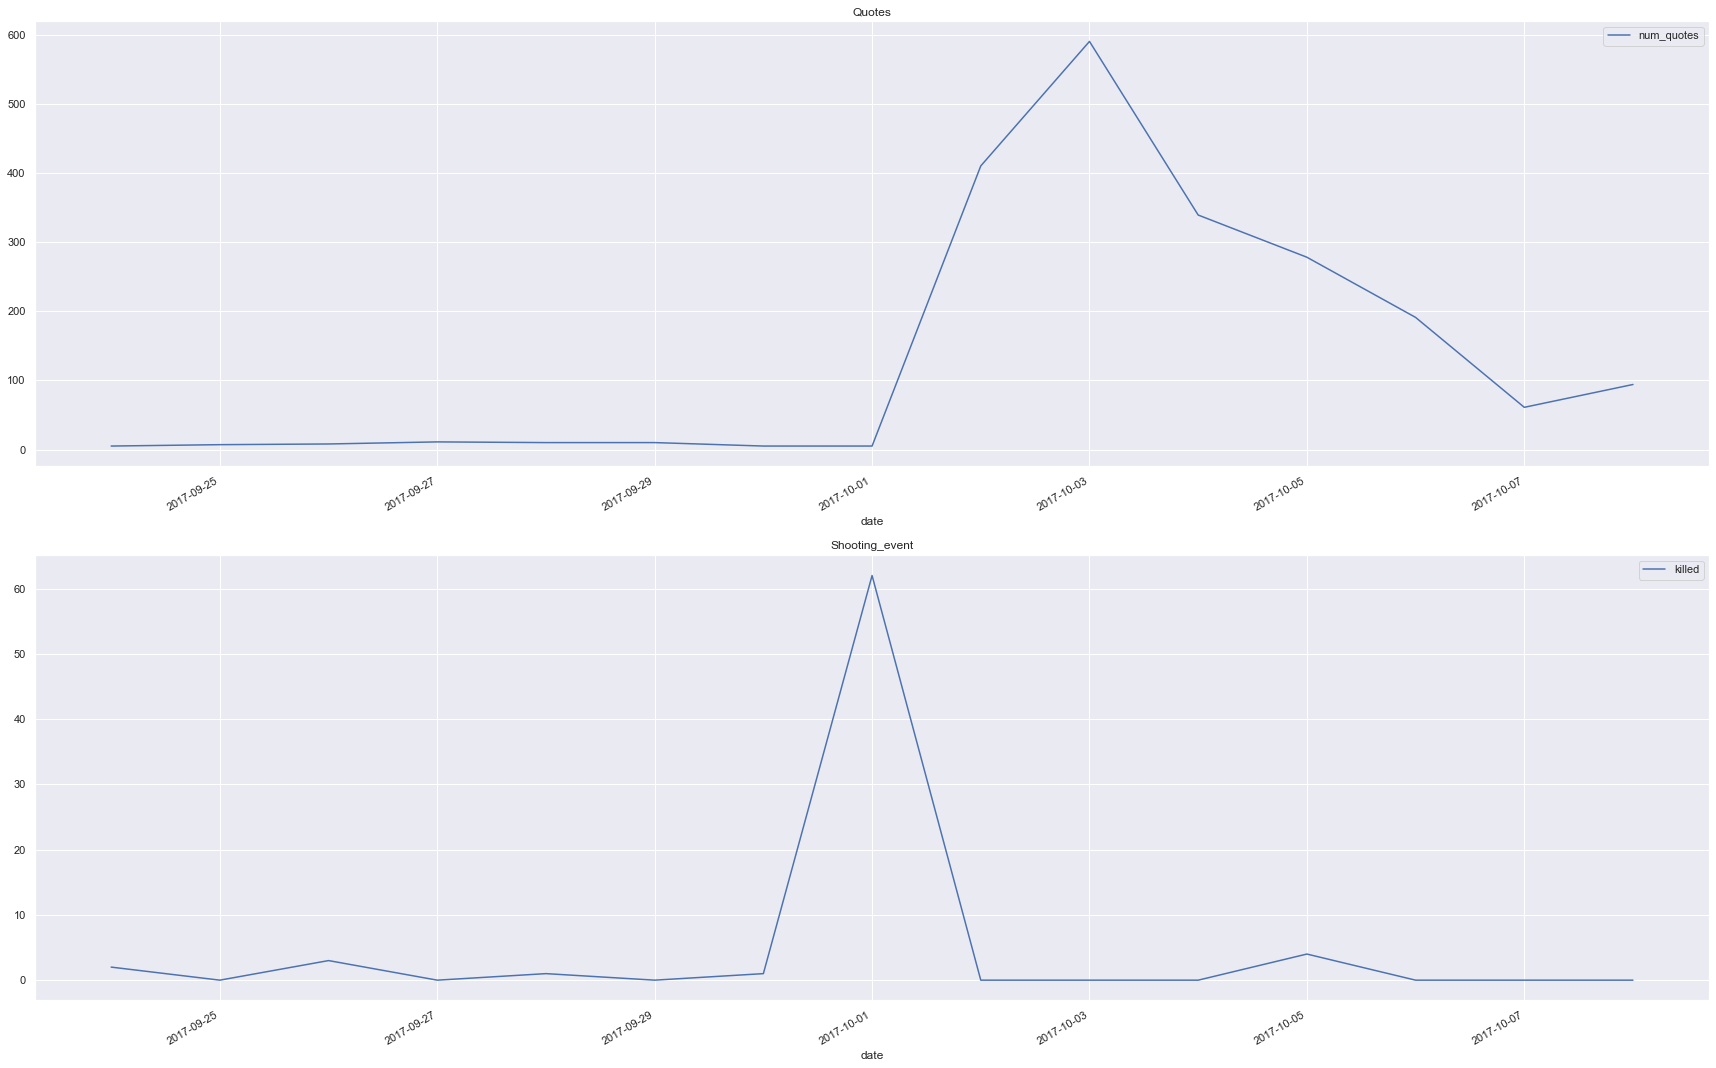

In [204]:
fig, axs = plt.subplots(2, 1)

event.plot(x='date', y='killed', figsize=(30,20), ax=axs[1], grid='True');
event.plot(x='date', y='num_quotes', figsize=(30,20), ax=axs[0], grid='True');
axs[0].set_title('Quotes');
axs[1].set_title('Shooting_event');

In [205]:
def crosscorr(datax, datay, lag=0, wrap=False):
    """ Lag-N cross correlation. 
    Shifted data filled with NaNs 
    Code take from https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9
    Parameters
    ----------
    lag : int, default 0
    datax, datay : pandas.Series objects of equal length
    Returns
    ----------
    crosscorr : float
    """
    if wrap:
        shiftedy = datay.shift(lag)
        shiftedy.iloc[:lag] = datay.iloc[-lag:].values
        return datax.corr(shiftedy)
    else: 
        return datax.corr(datay.shift(lag))



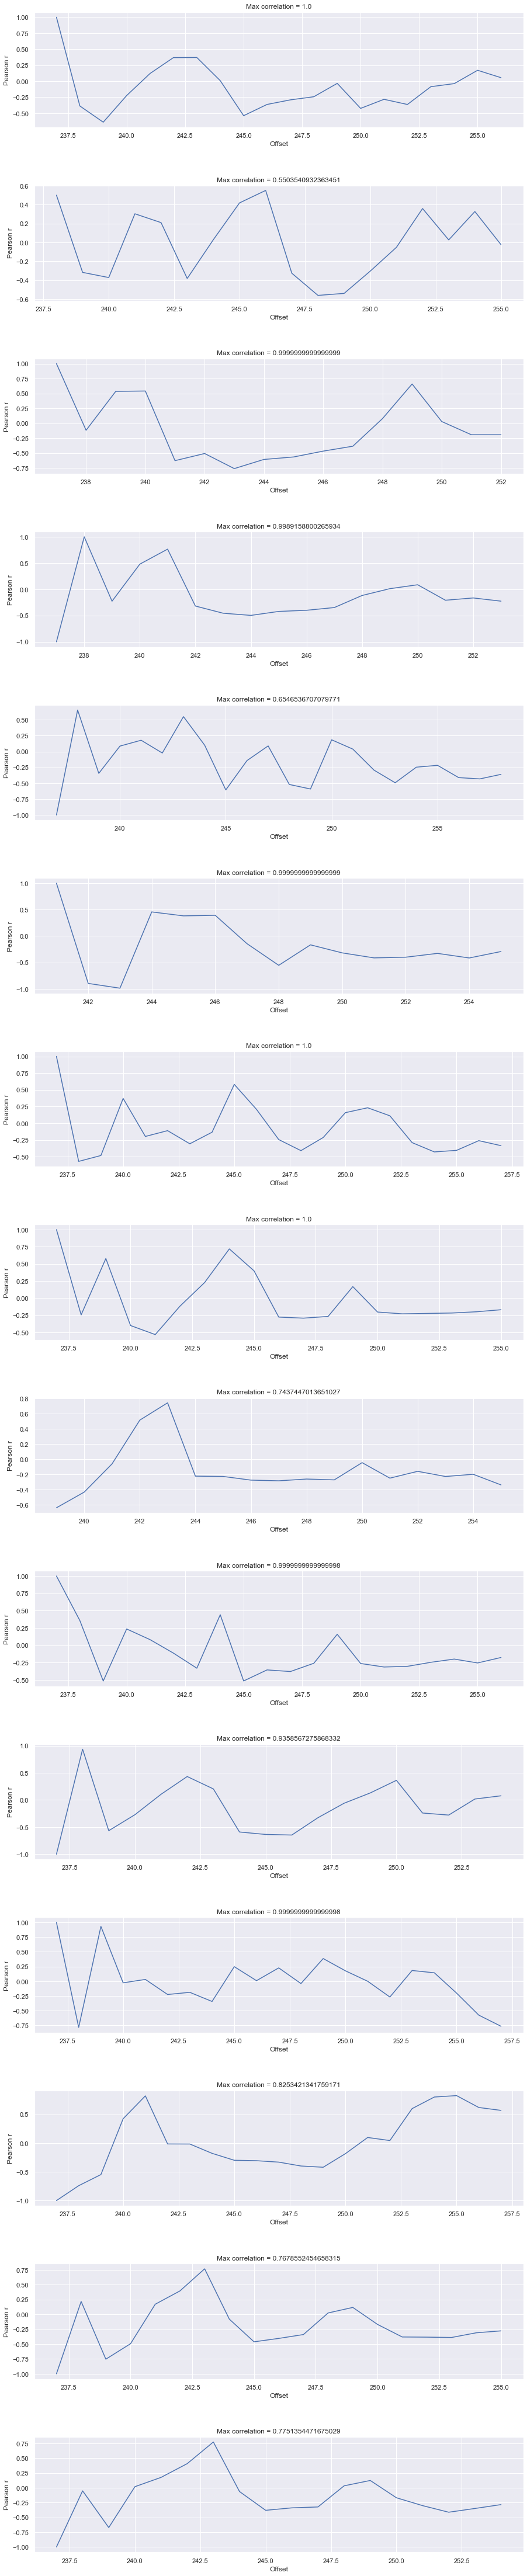

In [247]:
f,ax=plt.subplots(np.shape(selected_shooting)[0],1, figsize=(15,80))
f.subplots_adjust(hspace=0.5)
for i in range(np.shape(selected_shooting)[0]):
    event = death_and_quotes[(death_and_quotes['date']>=selected_shooting.iloc[i].date-pd.tseries.offsets.DateOffset(weeks=1)) & (death_and_quotes['date']<=selected_shooting.iloc[i].date+pd.tseries.offsets.DateOffset(weeks=1))]
    d1 = event.killed
    d2 = event.num_quotes
    seconds = 5
    fps = 50
    rs = [crosscorr(d1,d2, lag) for lag in range(-int(seconds*fps),int(seconds*fps+1))]
    offset = np.floor(len(rs)/2)-np.argmax(rs)

    ax[i].plot(rs)
    rs = [x for x in rs if np.isnan(x) == False]
    ax[i].set(title=f'Max correlation = {max(rs)}', xlabel='Offset',ylabel='Pearson r');
    